In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA

Portfolio returns during the crisis

The first step in quantifying the effects of uncertainty on a financial portfolio is to examine the portfolio's return. You'll consider a portfolio of four investment bank stocks, which were both instigators and victims of the global financial crisis.

The banks are Citibank, Goldman Sachs, J.P. Morgan, and Morgan Stanley. Closing stock prices for the period 2005 - 2010 are in the available portfolio DataFrame. You'll use this to examine the dramatic price changes during the depths of the crisis, 2008 - 2009. You'll also see how volatile the resulting portfolio_returns were, assuming an equal-weighted portfolio with weights stored in the weights list.

In [2]:
portfolio = pd.read_csv('crisis_portfolio.csv', index_col=0)
portfolio.index = pd.to_datetime(portfolio.index)
portfolio

C:\Users\Alienware\AppData\Local\Temp\ipykernel_21264\3914947465.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  portfolio.index = pd.to_datetime(portfolio.index)


,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
2004-12-31,481.799988,55.520000,104.040001,39.009998
2005-01-03,482.700012,55.900002,104.949997,39.150002
2005-01-04,478.600006,55.299999,104.269997,38.410000
2005-01-05,484.600006,54.980000,103.800003,38.490002
2005-01-06,489.299988,56.279999,105.230003,38.709999
...,...,...,...,...
2010-12-23,46.799999,27.410000,167.600006,42.080002
2010-12-27,47.700001,27.510000,169.830002,42.669998
2010-12-28,47.799999,27.660000,169.190002,42.610001


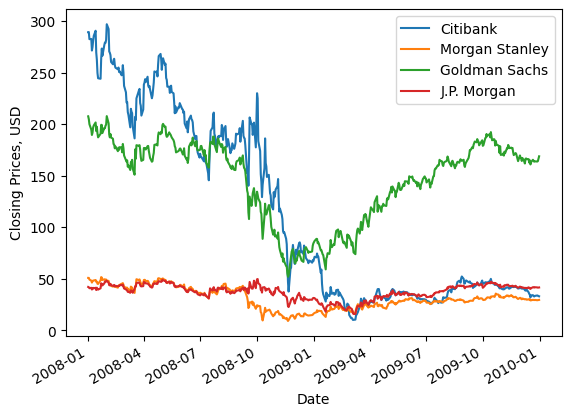

In [3]:
# Select portfolio asset prices for the middle of the crisis, 2008-2009
asset_prices = portfolio.loc['2008-01-01':'2009-12-31']

# Plot portfolio's asset prices during this time
asset_prices.plot().set_ylabel("Closing Prices, USD")
plt.show()

In [4]:
# Compute the portfolio's daily returns
asset_returns = asset_prices.pct_change()
asset_returns

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
2008-01-02,NaN,NaN,NaN,NaN
2008-01-03,0.000346,-0.000196,-0.013295,-0.006877
2008-01-04,-0.023851,-0.032195,-0.023970,-0.022684
2008-01-07,0.000708,-0.020081,-0.026009,0.010017
2008-01-08,-0.039632,-0.039536,-0.026858,-0.039671
...,...,...,...,...
2009-12-24,0.018237,0.006460,0.002078,0.007940
2009-12-28,0.011940,-0.010473,-0.001281,-0.004058
2009-12-29,-0.005900,0.004780,0.002198,-0.005513


In [5]:
weights = [0.25, 0.25, 0.25, 0.25]

portfolio_returns = asset_returns.dot(weights)
portfolio_returns

Date
2008-01-02         NaN
2008-01-03   -0.005006
2008-01-04   -0.025675
2008-01-07   -0.008841
2008-01-08   -0.036424
                ...   
2009-12-24    0.008679
2009-12-28   -0.000968
2009-12-29   -0.001109
2009-12-30    0.000972
2009-12-31    0.004232
Length: 505, dtype: float64

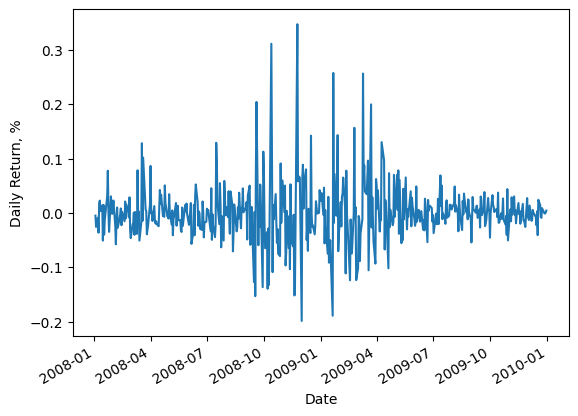

In [6]:
# Plot portfolio returns
portfolio_returns.plot().set_ylabel("Daily Return, %")
plt.show()
# The 'spikiness' of portfolio returns indicates how uncertain and volatile asset returns became.

Asset covariance and portfolio volatility

Now that you've examined the return of the portfolio of investment banks, it's time to assess the riskiness of the portfolio using the covariance matrix to determine the portfolio's volatility.

First you'll compute the covariance between the asset_returns and identify which of the banks had the highest volatility during the 2008-2009 crisis period.

Then, given the weights of an equal-weighted portfolio, you'll find the portfolio's annualized volatility for that period using portfolio_returns.

Finally, you'll use a 30-day window to create a time series of the volatility, and visualize this with a plot.

In [7]:
# Generate the covariance matrix from portfolio asset's returns
covariance = asset_returns.cov()

# Annualize the covariance using 252 trading days per year
covariance = covariance * 252

covariance

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,1.475195,0.821707,0.573790,0.724639
Morgan Stanley,0.821707,1.298341,0.658895,0.560523
Goldman Sachs,0.573790,0.658895,0.500807,0.426979
J.P. Morgan,0.724639,0.560523,0.426979,0.685584


In [8]:
# Compute and display portfolio volatility for 2008 - 2009
portfolio_variance = np.transpose(weights) @ covariance @ weights
# Compute portfolio_variance by using the @ matrix operator to multiply the transpose of weights, the covariance matrix, and untransposed weights
portfolio_variance

0.7183119341958923

In [9]:
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility

0.8475328513962702

In [10]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed = portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)
volatility_series

Date
2008-01-02         NaN
2008-01-03         NaN
2008-01-04         NaN
2008-01-07         NaN
2008-01-08         NaN
                ...   
2009-12-24    0.245894
2009-12-28    0.241735
2009-12-29    0.241782
2009-12-30    0.233580
2009-12-31    0.234701
Length: 505, dtype: float64

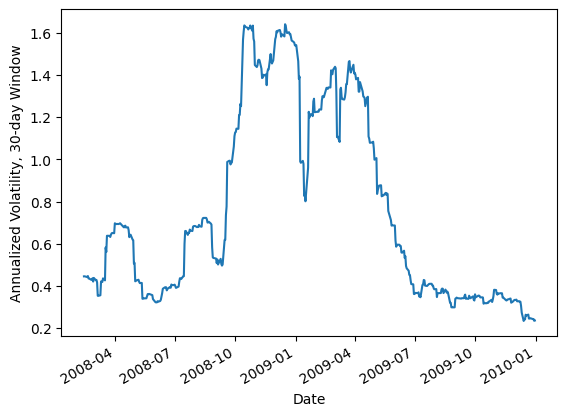

In [11]:
# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()
# The volatility plot shows that an equal-weighted portfolio of all four banks demonstrated a significant increase in volatility from late September 2008

Frequency resampling primer

Risk factor models often rely upon data that is of different frequencies. A typical example is when using quarterly macroeconomic data, such as prices, unemployment rates, etc., with financial data, which is often daily (or even intra-daily). To use both data sources in the same model, higher frequency data needs to be resampled to match the lower frequency data.

The DataFrame and Series Pandas objects have a built-in .resample() method that specifies the lower frequency. This method is chained with a method to create the lower-frequency statistic, such as .mean() for the average of the data within the new frequency period, or .min() for the minimum of the data.

In this exercise you'll practice converting daily returns data to weekly and quarterly frequency.

In [12]:
# Compute the portfolio's daily returns (all dates)
returns = portfolio.pct_change().dot(weights)
returns

Date
2004-12-31         NaN
2005-01-03    0.005262
2005-01-04   -0.011152
2005-01-05    0.001081
2005-01-06    0.013209
                ...   
2010-12-23   -0.005974
2010-12-27    0.012551
2010-12-28    0.000594
2010-12-29   -0.007729
2010-12-30   -0.000818
Length: 1511, dtype: float64

In [13]:
# Convert daily returns to quarterly average returns
returns_q_average = returns.resample('Q').mean()
returns_q_average

C:\Users\Alienware\AppData\Local\Temp\ipykernel_21264\3463655282.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  returns_q_average = returns.resample('Q').mean()


Date
2004-12-31         NaN
2005-03-31   -0.000367
2005-06-30   -0.000366
2005-09-30    0.000615
2005-12-31    0.001323
2006-03-31    0.001384
2006-06-30    0.000084
2006-09-30    0.001654
2006-12-31    0.001717
2007-03-31   -0.000200
2007-06-30    0.000509
2007-09-30   -0.001446
2007-12-31   -0.002300
2008-03-31   -0.002337
2008-06-30   -0.002166
2008-09-30    0.000943
2008-12-31   -0.003480
2009-03-31    0.002415
2009-06-30    0.004946
2009-09-30    0.004516
2009-12-31   -0.001940
2010-03-31    0.001330
2010-06-30   -0.002688
2010-09-30    0.001088
2010-12-31    0.002328
Freq: QE-DEC, dtype: float64

In [14]:
# Now convert daily returns to weekly minimum returns
returns_w_min = returns.resample('W').min()
returns_w_min

Date
2005-01-02         NaN
2005-01-09   -0.011152
2005-01-16   -0.007643
2005-01-23   -0.011076
2005-01-30   -0.000443
                ...   
2010-12-05   -0.009894
2010-12-12    0.001379
2010-12-19   -0.016622
2010-12-26   -0.005974
2011-01-02   -0.007729
Freq: W-SUN, Length: 314, dtype: float64

Visualizing risk factor correlation

Investment banks heavily invested in mortgage-backed securities (MBS) before and during the financial crisis. This makes MBS a likely risk factor for the investment bank portfolio. You'll assess this using scatterplots between portfolio returns and an MBS risk measure, the 90-day mortgage delinquency rate mort_del.

mort_del is only available as quarterly data. So portfolio_returns first needs to be transformed from daily to quarterly frequency using the DataFrame .resample() method.

In [15]:
mort_del = pd.read_csv('mortgage_delinquency.csv', index_col=0)
mort_del

,Mortgage Delinquency Rate
Date,
2005-03-31,0.0155
2005-06-30,0.0159
2005-09-30,0.0163
2005-12-31,0.0161
2006-03-31,0.0162
2006-06-30,0.0174
2006-09-30,0.0192
2006-12-31,0.0208
2007-03-31,0.0231


In [16]:
# Transform the daily portfolio_returns into quarterly average returns
portfolio_q_average = returns_q_average.dropna()
portfolio_q_average

Date
2005-03-31   -0.000367
2005-06-30   -0.000366
2005-09-30    0.000615
2005-12-31    0.001323
2006-03-31    0.001384
2006-06-30    0.000084
2006-09-30    0.001654
2006-12-31    0.001717
2007-03-31   -0.000200
2007-06-30    0.000509
2007-09-30   -0.001446
2007-12-31   -0.002300
2008-03-31   -0.002337
2008-06-30   -0.002166
2008-09-30    0.000943
2008-12-31   -0.003480
2009-03-31    0.002415
2009-06-30    0.004946
2009-09-30    0.004516
2009-12-31   -0.001940
2010-03-31    0.001330
2010-06-30   -0.002688
2010-09-30    0.001088
2010-12-31    0.002328
Freq: QE-DEC, dtype: float64

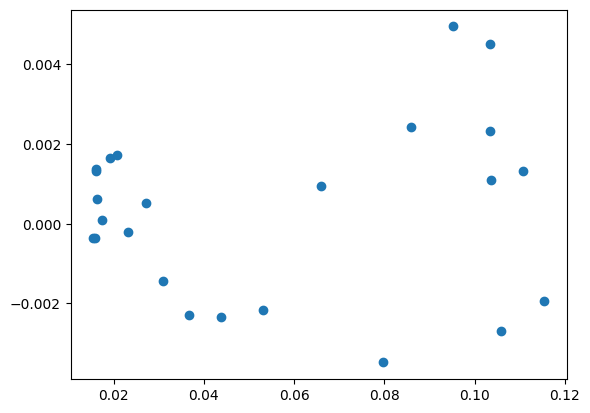

In [17]:
# Create a scatterplot between delinquency and quarterly average returns
plt.scatter(x=mort_del, y=portfolio_q_average)

In [18]:
# Transform daily portfolio_returns returns into quarterly minimum returns
portfolio_q_min = returns.resample('Q').min().dropna()
portfolio_q_min

C:\Users\Alienware\AppData\Local\Temp\ipykernel_21264\1296270179.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  portfolio_q_min = returns.resample('Q').min().dropna()


Date
2005-03-31   -0.021728
2005-06-30   -0.022794
2005-09-30   -0.014764
2005-12-31   -0.013551
2006-03-31   -0.028963
2006-06-30   -0.034735
2006-09-30   -0.019315
2006-12-31   -0.024550
2007-03-31   -0.052700
2007-06-30   -0.024104
2007-09-30   -0.053640
2007-12-31   -0.060247
2008-03-31   -0.057646
2008-06-30   -0.056931
2008-09-30   -0.153131
2008-12-31   -0.198734
2009-03-31   -0.189147
2009-06-30   -0.101852
2009-09-30   -0.054325
2009-12-31   -0.050587
2010-03-31   -0.051042
2010-06-30   -0.070714
2010-09-30   -0.034097
2010-12-31   -0.028097
Freq: QE-DEC, dtype: float64

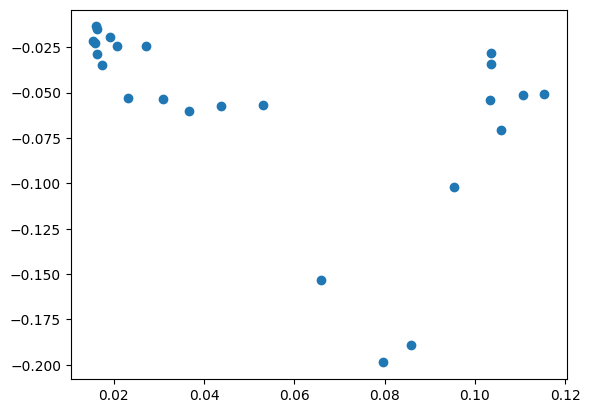

In [19]:
# Create a scatterplot between delinquency and quarterly minimum returns
plt.scatter(x=mort_del, y=portfolio_q_min)

Least-squares factor model

As you've seen, there is a negative correlation between minimum quarterly returns and mortgage delinquency rates from 2005 - 2010. This can be made more precise with an OLS regression factor model.

You'll compare three factor models with three different quarterly dependent variables: average returns, minimum returns, and average volatility. The independent variable is the mortgage delinquency rate. In the regression summary, examine the coefficients' t-statistic for statistical significance, as well as the overall R-squared for goodness of fit.

In [20]:
# Add a constant to the regression
mort_del = pd.DataFrame(sm.add_constant(mort_del))
mort_del.index = pd.to_datetime(mort_del.index)
mort_del

,const,Mortgage Delinquency Rate
Date,,
2005-03-31,1.0,0.0155
2005-06-30,1.0,0.0159
2005-09-30,1.0,0.0163
2005-12-31,1.0,0.0161
2006-03-31,1.0,0.0162
2006-06-30,1.0,0.0174
2006-09-30,1.0,0.0192
2006-12-31,1.0,0.0208
2007-03-31,1.0,0.0231


In [21]:
# Create the regression factor model against the minimum returns and fit it to the data
results_min = sm.OLS(portfolio_q_min, mort_del).fit()

results_min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.761
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0401
Time:                        03:02:21   Log-Likelihood:                 39.937
No. Observations:                  24   AIC:                            -75.87
Df Residuals:                      22   BIC:                            -73.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0279      0.017     -1.611      0.121      -0.064       0.008
Mortgage Delinquency Rate    -0.5664      0.260     -2.182      0.040      -1.105      -0.028
==============================================================================
Omnibus:                       13.525   Durbin-Watson:                   0.513
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               12.333
Skew:                          -1.534   Prob(JB):                      0.00210
Kurtosis:                       4.710   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Create the regression factor model against the average returns and fit it to the data
results_average = sm.OLS(portfolio_q_average, mort_del).fit()

results_average.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.4801
Date:                Tue, 25 Feb 2025   Prob (F-statistic):              0.496
Time:                        03:02:21   Log-Likelihood:                 113.89
No. Observations:                  24   AIC:                            -223.8
Df Residuals:                      22   BIC:                            -221.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0001      0.001     -0.175      0.862      -0.002       0.002
Mortgage Delinquency Rate     0.0083      0.012      0.693      0.496      -0.016       0.033
==============================================================================
Omnibus:                        0.081   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.293
Skew:                          -0.071   Prob(JB):                        0.864
Kurtosis:                       2.477   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Volatility on a 30 days rolling windows

roll_vol = returns.rolling(30).std() # *np.sqrt(252)
roll_vol

Date
2004-12-31         NaN
2005-01-03         NaN
2005-01-04         NaN
2005-01-05         NaN
2005-01-06         NaN
                ...   
2010-12-23    0.014272
2010-12-27    0.014294
2010-12-28    0.013875
2010-12-29    0.013898
2010-12-30    0.013523
Length: 1511, dtype: float64

In [24]:
# Quarterly resampled volatility

vol_q_mean = roll_vol.resample('Q').mean().dropna()
vol_q_mean

C:\Users\Alienware\AppData\Local\Temp\ipykernel_21264\1486146786.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  vol_q_mean = roll_vol.resample('Q').mean().dropna()


Date
2005-03-31    0.008443
2005-06-30    0.010162
2005-09-30    0.006568
2005-12-31    0.008331
2006-03-31    0.008348
2006-06-30    0.010891
2006-09-30    0.011391
2006-12-31    0.007944
2007-03-31    0.011416
2007-06-30    0.010885
2007-09-30    0.018846
2007-12-31    0.023776
2008-03-31    0.028066
2008-06-30    0.029841
2008-09-30    0.041124
2008-12-31    0.094289
2009-03-31    0.079853
2009-06-30    0.054279
2009-09-30    0.022798
2009-12-31    0.020090
2010-03-31    0.017484
2010-06-30    0.021403
2010-09-30    0.016759
2010-12-31    0.015765
Freq: QE-DEC, dtype: float64

In [25]:
# Create the regression factor model and fit it to the data
results = sm.OLS(vol_q_mean, mort_del).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     5.174
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0330
Time:                        03:02:21   Log-Likelihood:                 60.015
No. Observations:                  24   AIC:                            -116.0
Df Residuals:                      22   BIC:                            -113.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0100      0.007      1.339      0.194      -0.006       0.026
Mortgage Delinquency Rate     0.2558      0.112      2.275      0.033       0.023       0.489
==============================================================================
Omnibus:                       19.324   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.053
Skew:                           1.814   Prob(JB):                     9.87e-06
Kurtosis:                       6.145   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As seen from the regressions, mortgage delinquencies are acting as a systematic risk factor for both minimum quarterly returns and average volatility of returns, but _not_ for average quarterly returns. The R-squared goodness of fit isn't high in any case, but a model with more factors would likely generate greater explanatory power.

Practice with PyPortfolioOpt: returns
    
Modern Portfolio Theory is the cornerstone of portfolio risk management, because the efficient frontier is a standard method of assessing both investor risk appetite and market risk-return tradeoffs. In this exercise you'll develop powerful tools to explore a portfolio's efficient frontier, using the PyPortfolioOpt pypfopt Python library.

To compute the efficient frontier, both expected returns and the covariance matrix of the portfolio are required.

After some practice loading the investment bank price data, you'll use pypfopt.expected_returns's mean_historical_return method to compute and visualize the annualized average returns of each bank from daily asset prices. The following exercise will then cover the covariance matrix.

In [26]:
# Compute the annualized average historical return
mean_returns = mean_historical_return(portfolio, frequency = 252)
mean_returns

Citibank         -0.320429
Morgan Stanley   -0.111555
Goldman Sachs     0.082867
J.P. Morgan       0.013324
dtype: float64

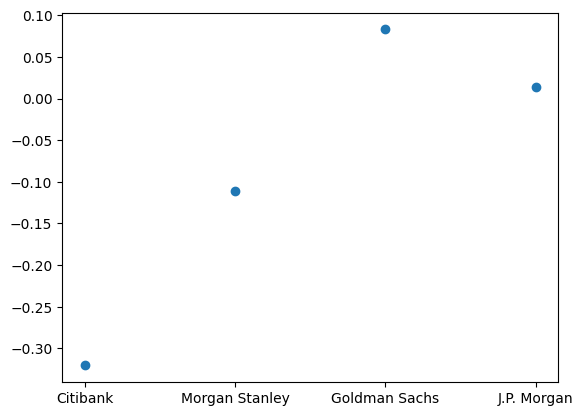

In [27]:
# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o')
plt.show()

Practice with PyPortfolioOpt: covariance
    
Portfolio optimization relies upon an unbiased and efficient estimate of asset covariance. Although sample covariance is unbiased, it is not efficient--extreme events tend to be overweighted.

One approach to alleviate this is through "covariance shrinkage", where large errors are reduced ('shrunk') to improve efficiency. In this exercise, you'll use pypfopt.risk_models's CovarianceShrinkage object to transform sample covariance into an efficient estimate. The textbook error shrinkage method, .ledoit_wolf(), is a method of this object.

Asset prices are available in your workspace. Note that although the CovarianceShrinkage object takes prices as input, it actually calculates the covariance matrix of asset returns, not prices.

In [28]:
# Compute the sample covariance matrix of returns
sample_cov = portfolio.pct_change().cov() * 252
sample_cov

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,0.536214,0.305045,0.217993,0.269784
Morgan Stanley,0.305045,0.491993,0.258625,0.218310
Goldman Sachs,0.217993,0.258625,0.217686,0.170937
J.P. Morgan,0.269784,0.218310,0.170937,0.264315


In [29]:
# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(portfolio)

# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()
e_cov

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Citibank,0.527505,0.288782,0.206371,0.255401
Morgan Stanley,0.288782,0.485642,0.244837,0.206671
Goldman Sachs,0.206371,0.244837,0.225959,0.161823
J.P. Morgan,0.255401,0.206671,0.161823,0.270102


Breaking down the financial crisis

You saw the efficient frontier for the portfolio of investment banks over the entire period 2005 - 2010, which includes time before, during and after the global financial crisis.

Here you'll break down this period into three sub-periods, or epochs: 2005-2006 (before), 2007-2008 (during) and 2009-2010 (after). For each period you'll compute the efficient covariance matrix, and compare them to each other.

In [30]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1-1-2005', 'end': '31-12-2006'},
           'during' : {'start': '1-1-2007', 'end': '31-12-2008'},
           'after'  : {'start': '1-1-2009', 'end': '31-12-2010'}
         }

epochs

{'before': {'start': '1-1-2005', 'end': '31-12-2006'},
 'during': {'start': '1-1-2007', 'end': '31-12-2008'},
 'after': {'start': '1-1-2009', 'end': '31-12-2010'}}

In [31]:
# Compute the efficient covariance for each epoch
e_cov = {}
periods_prices = {}

for x in epochs.keys():
    sub_price = portfolio.loc[epochs[x]['start']:epochs[x]['end']]
    print(x, epochs[x]['start'],epochs[x]['end'])
    periods_prices[x] = sub_price
    e_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()


before 1-1-2005 31-12-2006
during 1-1-2007 31-12-2008
after 1-1-2009 31-12-2010


In [32]:
# Display the efficient covariance matrices for all epochs

for epoch in epochs.keys():
    print(epoch, '\n', e_cov[epoch],'\n')

before 
                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.018149        0.013789       0.013183     0.013523
Morgan Stanley  0.013789        0.043021       0.030559     0.016525
Goldman Sachs   0.013183        0.030559       0.044482     0.018237
J.P. Morgan     0.013523        0.016525       0.018237     0.024182 

during 
                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.713035        0.465336       0.323977     0.364848
Morgan Stanley  0.465336        0.994390       0.434874     0.298613
Goldman Sachs   0.323977        0.434874       0.408773     0.224668
J.P. Morgan     0.364848        0.298613       0.224668     0.422516 

after 
                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.841156        0.344939       0.252684     0.356788
Morgan Stanley  0.344939        0.388839       0.231624     0.279727
Goldman Sachs   0.252684        0.231624       0.244539     0.223740
J.P.

The efficient frontier and the financial crisis

Previously you examined the covariance matrix of the investment bank portfolio before, during and after the financial crisis. Now you will visualize the changes that took place in the efficient frontier, showing how the crisis created a much higher baseline risk for any given return.

Using the PyPortfolioOpt pypfopt library's Critical Line Algorithm (CLA) object, you will derive and visualize the efficient frontier during the crisis period, and add it to a scatterplot already displaying the efficient frontiers before and after the crisis.

In [33]:
ecov_during = e_cov['during'].iloc[1:,1:]
ecov_during

,Morgan Stanley,Goldman Sachs,J.P. Morgan
Morgan Stanley,0.994390,0.434874,0.298613
Goldman Sachs,0.434874,0.408773,0.224668
J.P. Morgan,0.298613,0.224668,0.422516


In [34]:
all_returns_during = periods_prices['during'].pct_change()
all_returns_during

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
2007-01-03,NaN,NaN,NaN,NaN
2007-01-04,-0.003439,0.003553,-0.009316,0.002496
2007-01-05,-0.005267,-0.012819,0.001006,-0.008300
2007-01-08,0.005112,0.006060,0.023512,0.003348
2007-01-09,-0.008719,-0.002336,0.001718,-0.004171
...,...,...,...,...
2008-12-24,0.039877,0.004155,0.016489,0.025421
2008-12-26,-0.007375,0.010345,-0.006149,-0.001675
2008-12-29,-0.023774,0.017065,0.007766,-0.000671


In [35]:
cumulative_returns_during = (1 + all_returns_during).cumprod() -1
cumulative_returns_during

,Citibank,Morgan Stanley,Goldman Sachs,J.P. Morgan
Date,,,,
2007-01-03,NaN,NaN,NaN,NaN
2007-01-04,-0.003439,0.003553,-0.009316,0.002496
2007-01-05,-0.008688,-0.009311,-0.008320,-0.005825
2007-01-08,-0.003620,-0.003308,0.014996,-0.002496
2007-01-09,-0.012308,-0.005636,0.016740,-0.006657
...,...,...,...,...
2008-12-24,-0.877285,-0.822347,-0.619171,-0.379031
2008-12-26,-0.878190,-0.820510,-0.621513,-0.380071
2008-12-29,-0.881086,-0.817447,-0.618573,-0.380487


In [36]:
returns_during = cumulative_returns_during.iloc[-1][1:]
returns_during

Morgan Stanley   -0.803480
Goldman Sachs    -0.579564
J.P. Morgan      -0.344082
Name: 2008-12-31 00:00:00, dtype: float64

In [37]:
# Initialize the Crtical Line Algorithm object
efficient_portfolio_during = CLA(returns_during, ecov_during)

# Find the minimum volatility portfolio weights and display them
efficient_portfolio_during.min_volatility()

OrderedDict([('Morgan Stanley', 0.0),
             ('Goldman Sachs', 0.5179899476599341),
             ('J.P. Morgan', 0.48201005234006594)])

In [38]:
# Compute the efficient frontier
(ret_during, vol_during, weights_during) = efficient_portfolio_during.efficient_frontier()

len(ret_during), len(vol_during), len(weights_during)

(65, 65, 65)

In [39]:
# repeat for 'before'

ecov_before = e_cov['before'].iloc[1:,1:]
all_returns_before = periods_prices['before'].pct_change()
cumulative_returns_before = (1 + all_returns_before).cumprod() -1
returns_before = cumulative_returns_before.iloc[-1][1:]
efficient_portfolio_before = CLA(returns_before, ecov_before)
(ret_before, vol_before, weights_before) = efficient_portfolio_before.efficient_frontier()


In [40]:
# repeat for 'after'

ecov_after = e_cov['after'].iloc[1:,1:]
all_returns_after = periods_prices['after'].pct_change()
cumulative_returns_after = (1 + all_returns_after).cumprod() -1
returns_after = cumulative_returns_after.iloc[-1][1:]
efficient_portfolio_after = CLA(returns_after, ecov_after)
(ret_after, vol_after, weights_after) = efficient_portfolio_after.efficient_frontier()


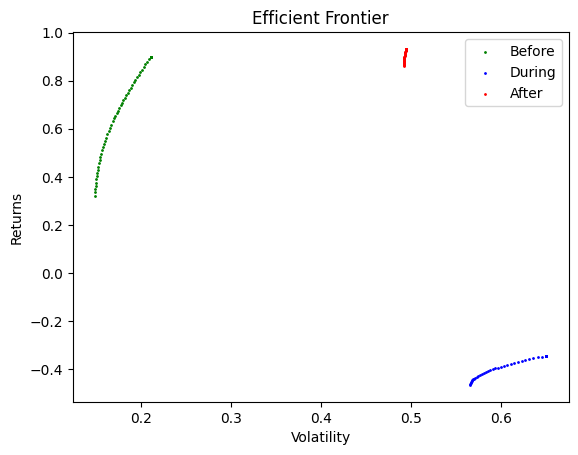

In [41]:
# Add the frontier to the plot showing the 'before', 'during' and 'after' frontiers
plt.scatter(vol_before, ret_before, s = 4, c = 'g', marker = '.', label = 'Before')
plt.scatter(vol_during, ret_during, s = 4, c = 'b', marker = '.', label = 'During')
plt.scatter(vol_after, ret_after, s = 4, c = 'r', marker = '.', label = 'After')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend()
plt.show()